In [21]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
from typing import List
import aplusml
from aplusml.models import Patient
import matplotlib.pyplot as plt

# Patient properties + model predictions
PATH_TO_INPUT_FOLDER = '../ignore/secure/hcm/'
PATH_TO_OUTPUT_FOLDER = '../ignore/secure/hcm/output/'
PATH_TO_PATIENT_PROPERTIES = None #os.path.join(PATH_TO_INPUT_FOLDER, 'properties.csv')

# Workflows
PATH_TO_BASE_YAML = 'workflows/hcm_base.yaml'
PATH_TO_AI_YAML = 'workflows/hcm_ai.yaml'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# HCM Tutorial

We use APLUS to compare model-guided workflows for HCM.

We use two workflow configuration files:
* `workflows/hcm_base.yaml` is the base workflow that we will use to model three workflows: current state, random, and optimistic.
* `workflows/hcm_ai.yaml` is the workflow that uses AI to guide the workflow.

### Base Workflow

Here, we print out the base workflow that we will slightly modify to model three workflows: current state, random, and optimistic.

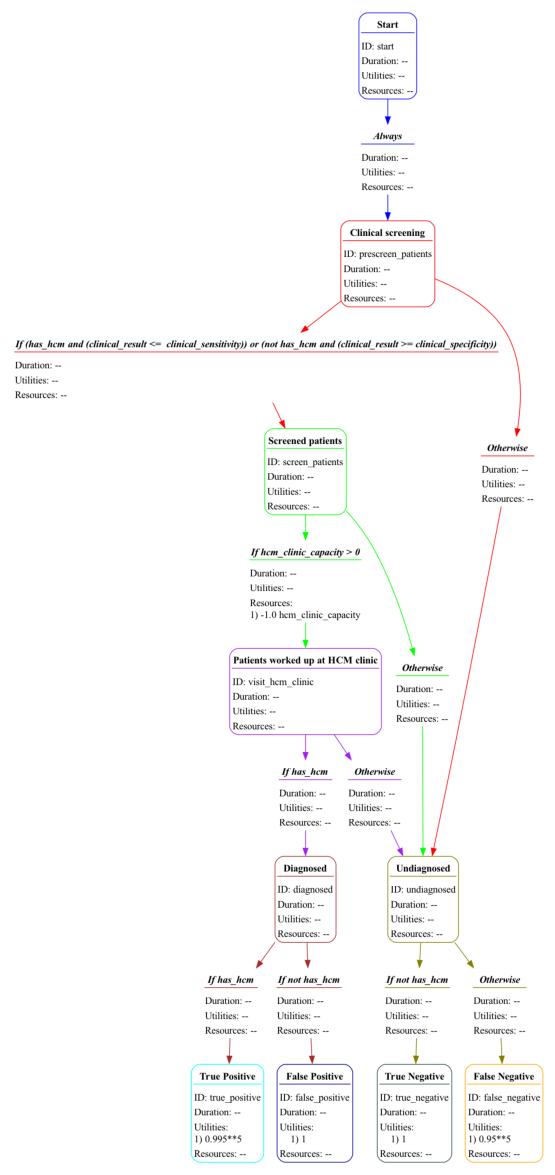

In [22]:
simulation = aplusml.Simulation.create_from_yaml(PATH_TO_BASE_YAML, PATH_TO_PATIENT_PROPERTIES)
simulation.draw_workflow_diagram(figsize=(15,15))

In [23]:
simulation

self.metadata:
    - name: HCM (Base for random / current / optimistic)
    - path_to_properties: None
    - properties_col_for_patient_id: None
    - patient_sort_preference_property: None

self.variables:
    - has_hcm: {'type': 'property', 'value': 'None'}
    - clinical_result: {'type': 'property', 'value': None, 'distribution': 'uniform', 'start': 0, 'end': 1}
    - clinical_sensitivity: {'type': 'scalar', 'value': 0.95}
    - clinical_specificity: {'type': 'scalar', 'value': 0.95}
    - hcm_clinic_capacity: {'type': 'resource', 'value': None, 'init_amount': 2, 'max_amount': 2, 'refill_amount': 2, 'refill_duration': 1}

self.states:
    - start
        - prescreen_patients
    - prescreen_patients
        - screen_patients
            if: (has_hcm and (clinical_result <=  clinical_sensitivity)) or (not has_hcm and (clinical_result >= clinical_specificity))
        - undiagnosed
    - screen_patients
        - visit_hcm_clinic
            if: hcm_clinic_capacity > 0
        - undia

In [24]:
def get_random() -> aplusml.Simulation:
    """Create a simulation for the "random" workflow"""
    simulation = aplusml.Simulation.create_from_yaml(PATH_TO_BASE_YAML, PATH_TO_PATIENT_PROPERTIES)
    # ignore clinical pre-screening
    simulation.states['start'].transitions[0].dest = 'screen_patients'
    del simulation.states['prescreen_patients']
    # relabel
    simulation.states['screen_patients'].label = 'Randomly screened patients'
    return simulation

def get_optimistic() -> aplusml.Simulation:
    """Create a simulation for the "optimistic" workflow"""
    simulation = aplusml.Simulation.create_from_yaml(PATH_TO_BASE_YAML, PATH_TO_PATIENT_PROPERTIES)
    # ignore clinical pre-screening AND HCM clinic capacity constraint
    simulation.states['start'].transitions[0].dest = 'visit_hcm_clinic'
    del simulation.states['prescreen_patients']
    del simulation.states['screen_patients']
    return simulation

def get_current() -> aplusml.Simulation:
    """Create a simulation for the "current" workflow"""
    simulation = aplusml.Simulation.create_from_yaml(PATH_TO_BASE_YAML, PATH_TO_PATIENT_PROPERTIES)
    # relabel
    simulation.states['screen_patients'].label = 'Randomly chosen patients (post-clinical screening)'
    return simulation

def get_ai() -> aplusml.Simulation:
    """Create a simulation for the "AI-guided" workflow"""
    simulation = aplusml.Simulation.create_from_yaml(PATH_TO_AI_YAML, PATH_TO_PATIENT_PROPERTIES)
    return simulation

#### Current Workflow

Let's see what the "current state" version of the workflow looks like.

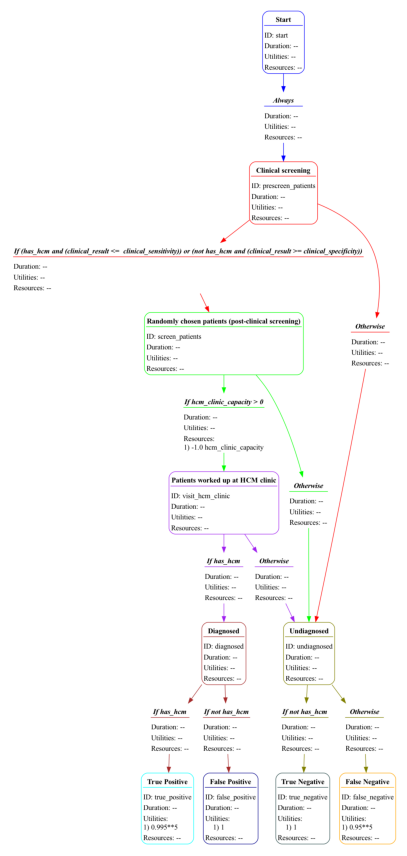

In [25]:
simulation = get_current()
simulation.draw_workflow_diagram(figsize=(5,20))

#### Random Workflow

Let's see what the "random" version of the workflow looks like.

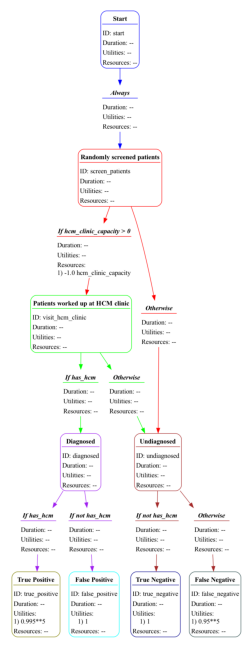

In [26]:
simulation = get_random()
simulation.draw_workflow_diagram(figsize=(3,20))

#### Optimistic Workflow

Let's see what the "optimistic" version of the workflow looks like.

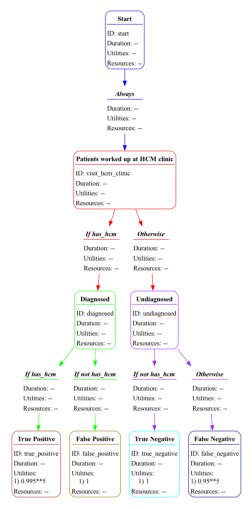

In [27]:
simulation = get_optimistic()
simulation.draw_workflow_diagram(figsize=(3,20))

### AI-Guided Workflow

Let's now see what the "AI-guided" version of the workflow looks like.

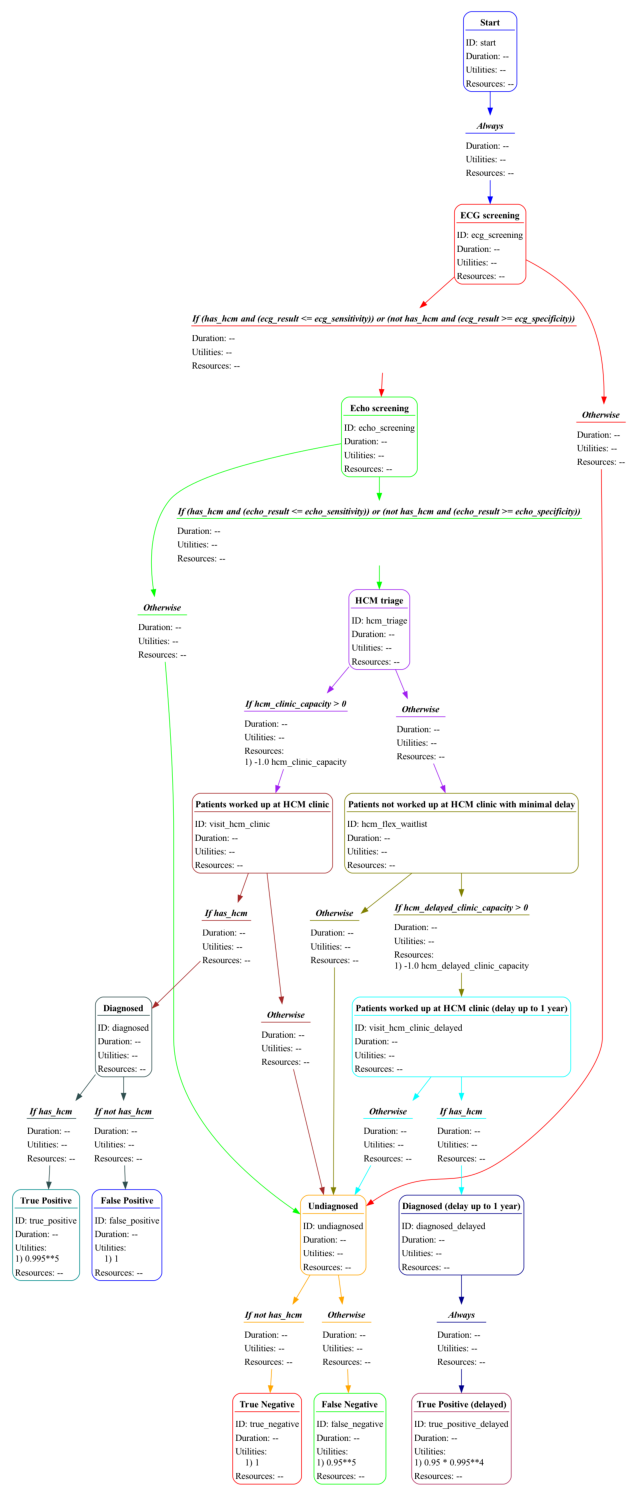

In [28]:
simulation = get_ai()
simulation.draw_workflow_diagram(figsize=(8,20))

## Run Simulations

Now that we've defined the 4 versions of our workflow, we can run the APLUS simulation.

First, let's generate some synthetic patients to simulate patient flow through the workflow.

We make the following assumptions, based on interviews with key stakeholders:

#### Patient Flow
* We'll simulate one full year patient flow, so `NUM_DAYS = 365`
* Our total cohort size is 150K patients / yr
* Thus, each day on average we'll see $k \sim \text{Poisson}(150000 // 365)$ patients.

#### Disease Prevalence
* The prevalence of HCM is `HCM_PREVALENCE = 1/200`

#### HCM Clinic
* The HCM clinic (`state = visit_hcm_clinic`) is open 7 days a week and has daily capacity of `HCM_CLINIC_CAPACITY = 2`
* The HCM clinic (`state = visit_hcm_clinic`) has perfect accuracy for diagnosing HCM
* We assume that, if a patient cannot be seen by HCM clinic within a year, they are unlikely to be diagnosed with HCM in the next 5 years 

#### Echo Screening
* We assume that all patients can receive an echocardiogram in a relatively short time compared to the waiting time for the HCM clinic (weeks to months vs. months to over a year)

#### Utilities
Our main utility is the annual risk of HCM-related death for each patient.
* True Positives: Annual mortality = 0.5%
* Delayed True Positives: Annual mortality = 5% the first year, 0.5% thereafter
* False Negatives: Annual mortality = 5%
* True Negatives: Annual mortality = 0
* False Positives: Annual mortality = 0

In [29]:
np.random.seed(0)

# Simulation parameters
NUM_DAYS: int = 365
MEAN_PATIENTS_PER_DAY: int = 150_000 // 365
HCM_PREVALENCE: float = 1 / 200
HCM_CLINIC_CAPACITY: int = 2

# Sample # of patients per day
num_admits_per_day = np.random.poisson(lam=MEAN_PATIENTS_PER_DAY, size=NUM_DAYS)

# Random indexes for resource prioritization
screen_idxs: List[int] = list(range(MEAN_PATIENTS_PER_DAY * NUM_DAYS * 10))
np.random.shuffle(screen_idxs)
delayed_screen_idxs: List[int] = list(range(MEAN_PATIENTS_PER_DAY * NUM_DAYS * 10))
np.random.shuffle(delayed_screen_idxs)

patients: List[Patient] = []
# Generate patients for each day
for timestep, n_patients in enumerate(num_admits_per_day):
    for x in range(n_patients):
        # Generate patient properties
        properties = {
            'has_hcm' : np.random.rand() < HCM_PREVALENCE,
        }
        patients.append(Patient(
            len(patients), # ID
            timestep, # Start timestep
            properties=properties,
        ))
print("# of patients: ", len(patients))
print("# of days: ", NUM_DAYS)
print("Mean # of patients per day: ", np.mean(num_admits_per_day))
print("HCM prevalence: ", np.mean([p.properties['has_hcm'] for p in patients]), "(expected prevalence =", HCM_PREVALENCE, ")")

# of patients:  149694
# of days:  365
Mean # of patients per day:  410.1205479452055
HCM prevalence:  0.005130466150947934 (expected prevalence = 0.005 )


### AI-Guided Workflow

Now, let's prepare the patients for the simulation.

We'll start by simulating the **AI-guided** workflow.

Note that we need to set `is_overwrite_existing_properties = False` to keep the patient properties that we manually set (otherwise they will be overwritten with the default values from the YAML file).

In [32]:
ai_simulation = get_ai()

# Remove the forced 'value' key so the simulation uses the distribution
for var_name in ['ecg_result', 'echo_result', 'clinical_result']:
    if var_name in ai_simulation.variables:
        ai_simulation.variables[var_name].pop('value', None)

ai_simulation
# patients = ai_simulation.create_patients_for_simulation(patients, random_seed=0, is_overwrite_existing_properties=True)
# patients[0]

self.metadata:
    - name: HCM (AI-Guided)
    - path_to_properties: None
    - properties_col_for_patient_id: None
    - patient_sort_preference_property: None

self.variables:
    - has_hcm: {'type': 'property', 'value': 'None'}
    - ecg_result: {'type': 'property', 'distribution': 'uniform', 'start': 0, 'end': 1}
    - echo_result: {'type': 'property', 'distribution': 'uniform', 'start': 0, 'end': 1}
    - ecg_sensitivity: {'type': 'scalar', 'value': 0.95}
    - ecg_specificity: {'type': 'scalar', 'value': 0.95}
    - echo_sensitivity: {'type': 'scalar', 'value': 0.95}
    - echo_specificity: {'type': 'scalar', 'value': 0.95}
    - hcm_clinic_capacity: {'type': 'resource', 'value': None, 'init_amount': 2, 'max_amount': 2, 'refill_amount': 2, 'refill_duration': 1}
    - hcm_delayed_clinic_capacity: {'type': 'resource', 'value': None, 'init_amount': 100, 'max_amount': 100, 'refill_amount': 100, 'refill_duration': 365}

self.states:
    - start
        - ecg_screening
    - ecg_screen

In [31]:
ai_simulation

self.metadata:
    - name: HCM (AI-Guided)
    - path_to_properties: None
    - properties_col_for_patient_id: None
    - patient_sort_preference_property: None

self.variables:
    - has_hcm: {'type': 'property'}
    - ecg_result: {'type': 'property', 'distribution': 'uniform', 'start': 0, 'end': 1}
    - echo_result: {'type': 'property', 'distribution': 'uniform', 'start': 0, 'end': 1}
    - ecg_sensitivity: {'type': 'scalar', 'value': 0.95}
    - ecg_specificity: {'type': 'scalar', 'value': 0.95}
    - echo_sensitivity: {'type': 'scalar', 'value': 0.95}
    - echo_specificity: {'type': 'scalar', 'value': 0.95}
    - hcm_clinic_capacity: {'type': 'resource', 'value': None, 'init_amount': 2, 'max_amount': 2, 'refill_amount': 2, 'refill_duration': 1}
    - hcm_delayed_clinic_capacity: {'type': 'resource', 'value': None, 'init_amount': 100, 'max_amount': 100, 'refill_amount': 100, 'refill_duration': 365}

self.states:
    - start
        - ecg_screening
    - ecg_screening
        - ech

Now that we have our patients and workflow defined, we can run the simulation.

Let's test it with one patient first.

In [19]:
ai_simulation.run(patients[:1], is_print_log=True)

Deep copying patients...
Done deep copying patients


Simulating patients: 100%|██████████| 1/1 [00:00<00:00, 3701.95it/s]

t=0 | Top of sim loop
t=0 | admitted_patients_idxs=[0:1] | earliest unfinished tuple=(1, 0) | finished=0 paused=0 unpaused=0
t=0 | Transition: (0) => ecg_screening
t=0 | Transition: (0) => echo_screening
t=0 | Transition: (0) => hcm_triage
t=0 | Transition: (0) => visit_hcm_clinic
t=0 | Transition: (0) => diagnosed
t=0 | Transition: (0) => true_positive
t=0 | Transition: (0) => N/A
t=0 | All patients are finished @ t=0


[Patient({'id': 0, 'start_timestep': 0, 'properties': {'has_hcm': 'None', 'ecg_result': 0.5488135039273248, 'echo_result': 0.11711118906913687}, 'history': [History({'current_timestep': 0, 'state_id': 'start', 'transition_idx': 0, 'state_utility_idxs': [], 'transition_utility_idxs': [], 'state_utility_vals': [], 'transition_utility_vals': []}), History({'current_timestep': 0, 'state_id': 'ecg_screening', 'transition_idx': 0, 'state_utility_idxs': [], 'transition_utility_idxs': [], 'state_utility_vals': [], 'transition_utility_vals': []}), History({'current_timestep': 0, 'state_id': 'echo_screening', 'transition_idx': 0, 'state_utility_idxs': [], 'transition_utility_idxs': [], 'state_utility_vals': [], 'transition_utility_vals': []}), History({'current_timestep': 0, 'state_id': 'hcm_triage', 'transition_idx': 0, 'state_utility_idxs': [], 'transition_utility_idxs': [], 'state_utility_vals': [], 'transition_utility_vals': []}), History({'current_timestep': 0, 'state_id': 'visit_hcm_clinic

This patient got ECG screening, but it was negative. They were then sent to the "Undiagnosed" state, where they ended up being a "True Negative" (i.e. they were correctly classified as not having HCM).

Now, let's run the simulation for all patients. *Note:* This will take ~30 seconds to run for 150K patients.

In [94]:
ai_patients: List[Patient] = ai_simulation.run(patients)

Simulating patients: 100%|██████████| 149694/149694 [00:11<00:00, 13444.83it/s]


Let's make sure we have all the patients we started with.

In [95]:
print("# of sim'd patients: ", len(ai_patients))
print("# of patients we started with: ", len(patients))
assert len(ai_patients) == len(patients)

# of sim'd patients:  149694
# of patients we started with:  149694


Let's plot a histogram of how many states each patient went through.

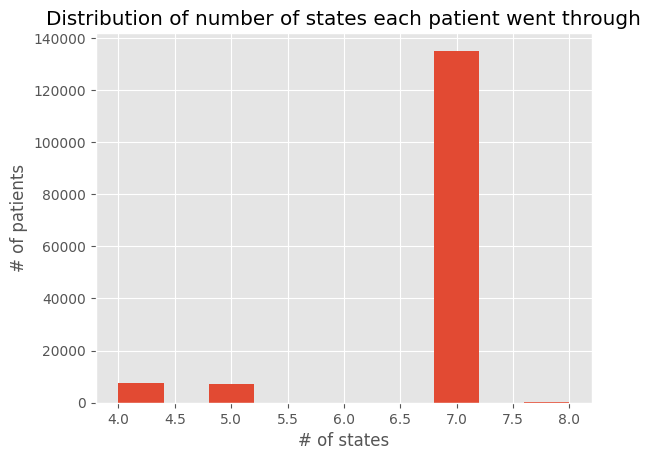

In [96]:
lens = [ len(p.get_state_history()) for p in ai_patients]
plt.hist(lens, bins=10)
plt.xlabel('# of states')
plt.ylabel('# of patients')
plt.title('Distribution of number of states each patient went through')
plt.show()

What were the most common pathways for patients?

In [97]:
from typing import Dict
import collections
import pandas as pd

paths: List[str] = [p.repr_state_history() for p in ai_patients]
path_counts: Dict[str, int] = collections.Counter(paths)
path_counts = sorted(path_counts.items(), key=lambda x: x[1], reverse=True)
df_outcomes = pd.DataFrame(path_counts, columns=['Path', 'Count'])
df_outcomes['Outcome'] = df_outcomes['Path'].apply(lambda x: ('T' if 'true_' in x else 'F') + ('P' if 'positive' in x else 'N'))
df_outcomes['Has HCM'] = df_outcomes['Outcome'].apply(lambda x: 'Y' if x in ['TP', 'FN'] else 'N')
pd.set_option('display.max_colwidth', None)  # Show full column content
df_outcomes

,Path,Count,Outcome,Has HCM
0,start > ecg_screening > echo_screening > hcm_triage > hcm_flex_waitlist > undiagnosed > false_negative,134330,FN,Y
1,start > ecg_screening > undiagnosed > false_negative,7469,FN,Y
2,start > ecg_screening > echo_screening > undiagnosed > false_negative,7065,FN,Y
3,start > ecg_screening > echo_screening > hcm_triage > visit_hcm_clinic > diagnosed > true_positive,730,TP,Y
4,start > ecg_screening > echo_screening > hcm_triage > hcm_flex_waitlist > visit_hcm_clinic_delayed > diagnosed_delayed > true_positive_delayed,100,TP,Y


Let's take a look at a few example patients.

In [98]:
# Patient that was a True Negative
tn = next((p for p in ai_patients if p.get_state_history()[-1] == 'true_negative'), None)
# Patient that was a True Positive
tp = next((p for p in ai_patients if p.get_state_history()[-1] == 'true_positive'), None)
# Patient that was a False Positive
fp = next((p for p in ai_patients if p.get_state_history()[-1] == 'false_positive'), None)
# Patient that was a False Negative
fn = next((p for p in ai_patients if p.get_state_history()[-1] == 'false_negative'), None)

print("True Negative:  ", tn.repr_state_history() if tn else None)
print("True Positive:  ", tp.repr_state_history() if tp else None)
print("False Positive: ", fp.repr_state_history() if fp else None)
print("False Negative: ", fn.repr_state_history() if fn else None)

True Negative:   None
True Positive:   start > ecg_screening > echo_screening > hcm_triage > visit_hcm_clinic > diagnosed > true_positive
False Positive:  None
False Negative:  start > ecg_screening > undiagnosed > false_negative


Finally, let's make a quick back-of-the-envelope estimate of the utility of the AI-guided workflow.

In [99]:
UTILITY_UNIT: str = 'five_year_life_expectancy'
ai_sum_utilities = sum([ p.get_sum_utilities(ai_simulation)[UTILITY_UNIT] for p in ai_patients ])
print(f"Average life expectancy of patients in AI-guided workflow: {ai_sum_utilities / len(ai_patients)}")

Average life expectancy of patients in AI-guided workflow: 0.7748685403033762


### Baseline Workflows

Let's repeat this process for the other three workflows.

In [ ]:
# Random Workflow
random_simulation = get_random()
patients = random_simulation.create_patients_for_simulation(patients, random_seed=0, is_overwrite_existing_properties=False)
random_patients: List[Patient] = random_simulation.run(patients)

# Optimistic Workflow
optimistic_simulation = get_optimistic()
patients = optimistic_simulation.create_patients_for_simulation(patients, random_seed=0, is_overwrite_existing_properties=False)
optimistic_patients: List[Patient] = optimistic_simulation.run(patients)

# Current Workflow
current_simulation = get_current()
patients = current_simulation.create_patients_for_simulation(patients, random_seed=0, is_overwrite_existing_properties=False)
current_patients: List[Patient] = current_simulation.run(patients)


Simulating patients:  37%|███▋      | 54836/149694 [00:01<00:01, 59972.22it/s]Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x10b8b8350>>
Traceback (most recent call last):
  File "/Users/audreyxychang/Documents/GitHub/hcm-subgroup/.venv/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(

KeyboardInterrupt: 
Simulating patients:  44%|████▍     | 66162/149694 [00:06<00:11, 7010.93it/s] 

And let's compare each workflow's achieved utilities.

In [ ]:
# Compare Utilities
random_sum_utilities = sum([ p.get_sum_utilities(random_simulation)[UTILITY_UNIT] for p in random_patients ])
optimistic_sum_utilities = sum([ p.get_sum_utilities(optimistic_simulation)[UTILITY_UNIT] for p in optimistic_patients ])
current_sum_utilities = sum([ p.get_sum_utilities(current_simulation)[UTILITY_UNIT] for p in current_patients ])

print(f"Predicted deaths within 5-yrs in Current workflow:    {(len(current_patients) - current_sum_utilities):.2f}")
print(f"Predicted deaths within 5-yrs in Random workflow:     {(len(random_patients) - random_sum_utilities):.2f}")
print(f"Predicted deaths within 5-yrs in AI-guided workflow:  {(len(ai_patients) - ai_sum_utilities):.2f}")
print(f"Predicted deaths within 5-yrs in Optimistic workflow: {(len(optimistic_patients) - optimistic_sum_utilities):.2f}")

Predicted deaths within 5-yrs in Random workflow:     33716.56
Predicted deaths within 5-yrs in AI-guided workflow:  33700.83
Predicted deaths within 5-yrs in Optimistic workflow: 3705.11
